<a href="https://colab.research.google.com/github/Fidelisaboke/robust-nids/blob/feat%2Fbaseline-model/notebooks/04_baseline_model_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Baseline Model Training

## Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Ensure Libraries are updated

In [ ]:
!pip install --upgrade scikit-learn
!pip install --upgrade xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 37.1 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1


## Required Libraries

In [ ]:
# =========================================
# Setup & Configuration
# =========================================
import os
import json
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# Scikit-learn: Data Handling & Pipelines
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif

# Models (Supervised)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Models (Unsupervised)
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor
from sklearn.covariance import EllipticEnvelope

# Tensorflow / Keras for Autoencoder
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import regularizers

# Metrics
from sklearn.metrics import (
    classification_report, confusion_matrix,
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, precision_recall_curve, auc,
    precision_recall_fscore_support, roc_curve
)

## Constants and Configuration

In [ ]:
# --- Configuration ---
BASE_DIR = "/content/drive/MyDrive/Datasets/TII-SSRC-23/"
ARTIFACTS_DIR = os.path.join(BASE_DIR, "Artifacts/")
os.makedirs(ARTIFACTS_DIR, exist_ok=True)

# Paths
PATHS = {
    "CLEAN_DATA": os.path.join(BASE_DIR, "cleaned_data.csv"),
    "BINARY_PIPELINE": os.path.join(ARTIFACTS_DIR, "binary_pipeline.pkl"),
    "MULTICLASS_PIPELINE": os.path.join(ARTIFACTS_DIR, "multiclass_pipeline.pkl"),
    "LABEL_ENCODER": os.path.join(ARTIFACTS_DIR, "label_encoder.pkl"),
    "UNSUPERVISED_PIPELINE": os.path.join(ARTIFACTS_DIR, "unsupervised_pipeline.pkl"),
    "SUPERVISED_PIPELINE": os.path.join(ARTIFACTS_DIR, "supervised_pipeline.pkl"),
    "AUTOENCODER_MODEL": os.path.join(ARTIFACTS_DIR, "autoencoder_model.keras"),
    "AE_THRESHOLD": os.path.join(ARTIFACTS_DIR, "ae_threshold.txt"),
}

# Set seeds for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)

## Load the Dataset

In [ ]:
# Load dataset
df = pd.read_csv(PATHS["CLEAN_DATA"])
df.head()

,ACK Flag Count,Active Max,Active Mean,Active Min,Active Std,Average Packet Size,Bwd Bulk Rate Avg,Bwd Bytes/Bulk Avg,Bwd Header Length,Bwd IAT Max,...,Total Bwd packets,Total Fwd Packet,Total Length of Bwd Packet,Total Length of Fwd Packet,Traffic Subtype,Traffic Type,URG Flag Count,Protocol_0,Protocol_17,Protocol_6
0,0.0,0.0,0.0,0.0,0.0,1690.0,0.0,0.0,0.0,0.0,...,0.0,4.0,0.0,5404.0,DoS URG,DoS,4.0,0.0,0.0,1.0
1,1.0,1234227.0,1234227.0,1234227.0,0.0,50.0,0.0,0.0,20.0,0.0,...,1.0,4.0,0.0,200.0,DoS PSH,DoS,0.0,0.0,0.0,1.0
2,1.0,0.0,0.0,0.0,0.0,500.0,0.0,0.0,20.0,0.0,...,1.0,1.0,0.0,500.0,DoS CWR,DoS,0.0,0.0,0.0,1.0
3,1.0,0.0,0.0,0.0,0.0,50.0,0.0,0.0,20.0,0.0,...,1.0,1.0,0.0,50.0,DoS ACK,DoS,0.0,0.0,0.0,1.0
4,0.0,0.0,0.0,0.0,0.0,58.5,0.0,0.0,8.0,0.0,...,1.0,1.0,39.0,39.0,Bruteforce DNS,Bruteforce,0.0,0.0,1.0,0.0


## Supervised Learning - Classification

### Separate Features (X) and Targets (y)

In [ ]:
# Separate Features (X) and Targets (y)
drop_cols = ["Label", "Traffic Type", "Traffic Subtype"]
X = df.drop(columns=[c for c in drop_cols if c in df.columns])
y_binary = df["Label"]
y_multi = df["Traffic Type"]

print(f"Data Shape: {X.shape}")
print("Class Imbalance (Binary):\n", y_binary.value_counts(normalize=True))

Data Shape: (235453, 81)
Class Imbalance (Binary):
 Label
1    0.919207
0    0.080793
Name: proportion, dtype: float64


### Split into Train (70%), Validation (15%), and Testing (15%)

In [ ]:
# 1. Split into Train (70%) and Temp (30%)
X_train, X_temp, y_bin_train, y_bin_temp, y_mul_train, y_mul_temp = train_test_split(
    X, y_binary, y_multi,
    test_size=0.3,
    stratify=y_multi,
    random_state=RANDOM_STATE
)

# 2. Split Temp into Validation (15%) and Test (15%)
X_val, X_test, y_bin_val, y_bin_test, y_mul_val, y_mul_test = train_test_split(
    X_temp, y_bin_temp, y_mul_temp,
    test_size=0.5,
    stratify=y_mul_temp,
    random_state=RANDOM_STATE
)

# Train-Val-Test sizes
print(f"Train size: {X_train.shape[0]} rows")
print(f"Val size:   {X_val.shape[0]} rows")
print(f"Test size:  {X_test.shape[0]} rows")

# Ensure indices actually match
assert X_train.index.equals(y_mul_train.index), "FATAL: Train indices don't match!"
assert X_val.index.equals(y_mul_val.index), "FATAL: Val indices don't match!"
print("Safety check passed: Indices are aligned.")

Train size: 164817 rows
Val size:   35318 rows
Test size:  35318 rows
Safety check passed: Indices are aligned.


#### Training columns

In [ ]:
print(X_train.columns.tolist())

['ACK Flag Count', 'Active Max', 'Active Mean', 'Active Min', 'Active Std', 'Average Packet Size', 'Bwd Bulk Rate Avg', 'Bwd Bytes/Bulk Avg', 'Bwd Header Length', 'Bwd IAT Max', 'Bwd IAT Mean', 'Bwd IAT Min', 'Bwd IAT Std', 'Bwd IAT Total', 'Bwd Init Win Bytes', 'Bwd PSH Flags', 'Bwd Packet Length Max', 'Bwd Packet Length Mean', 'Bwd Packet Length Min', 'Bwd Packet Length Std', 'Bwd Packet/Bulk Avg', 'Bwd Packets/s', 'Bwd Segment Size Avg', 'Bwd URG Flags', 'CWR Flag Count', 'Down/Up Ratio', 'Dst Port', 'ECE Flag Count', 'FIN Flag Count', 'FWD Init Win Bytes', 'Flow Bytes/s', 'Flow Duration', 'Flow IAT Max', 'Flow IAT Mean', 'Flow IAT Min', 'Flow IAT Std', 'Flow Packets/s', 'Fwd Act Data Pkts', 'Fwd Bulk Rate Avg', 'Fwd Bytes/Bulk Avg', 'Fwd Header Length', 'Fwd IAT Max', 'Fwd IAT Mean', 'Fwd IAT Min', 'Fwd IAT Std', 'Fwd IAT Total', 'Fwd PSH Flags', 'Fwd Packet Length Max', 'Fwd Packet Length Mean', 'Fwd Packet Length Min', 'Fwd Packet Length Std', 'Fwd Packet/Bulk Avg', 'Fwd Packets/

### Preprocessing Pipeline Construction
- We use a Pipeline to ensure all steps (scaling, feature selection) are fitted only on the training data and applied identically to val/test.

In [ ]:
# Identify column types automatically
categorical_cols = [col for col in X.columns if "Protocol_" in col] # Already OHE, but good to track
numerical_cols = [col for col in X.columns if col not in categorical_cols]

# 1. Numeric Transformer: Handle missing -> Scale
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')), # Safety net for NaNs
    ('scaler', MinMaxScaler())
])

# 2. Column Transformer: Apply above to correct columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_cols),
        ('cat', 'passthrough', categorical_cols)
    ])

# 3. Feature Selection: Remove constant features -> Select Top K
selector = Pipeline(steps=[
    ('variance_threshold', VarianceThreshold(threshold=0.0)),
    ('k_best', SelectKBest(score_func=f_classif, k=30)) # Start with top 30 features
])

# Save the preprocessor pipeline
joblib.dump(preprocessor, PATHS["SUPERVISED_PIPELINE"])
print("Preprocessor saved.")
print("Pipeline components defined.")

Preprocessor saved.
Pipeline components defined.


### Binary Classification (Comparison)

In [ ]:
# =========================================
# Binary Classification (Comparison)
# =========================================
print("\n--- Training Binary Classifiers ---")

# Calculate weighting for imbalance
neg_count = (y_bin_train == 0).sum()
pos_count = (y_bin_train == 1).sum()
xgb_scale_weight = neg_count / pos_count

# Define models to test
binary_models = {
    "Logistic Regression": LogisticRegression(class_weight='balanced', max_iter=1000, random_state=RANDOM_STATE),
    "Random Forest": RandomForestClassifier(n_estimators=100, class_weight='balanced', n_jobs=-1, random_state=RANDOM_STATE),
    "XGBoost": XGBClassifier(scale_pos_weight=xgb_scale_weight, eval_metric='logloss', n_jobs=-1, random_state=RANDOM_STATE)
}

binary_results = {}
binary_predictions = {}
best_binary_score = 0
best_binary_model_name = ""
best_binary_pipeline = None

for name, model in tqdm(binary_models.items(), desc="Binary Models"):
    # Create full pipeline for this model
    pipe = Pipeline([
        ('preprocessor', preprocessor),
        ('selector', selector),
        ('model', model)
    ])

    # Train
    pipe.fit(X_train, y_bin_train)

    # Evaluate on Validation
    y_pred = pipe.predict(X_val)
    binary_predictions[name] = y_pred
    f1 = f1_score(y_bin_val, y_pred, pos_label=1) # Focus on Malicious class F1

    binary_results[name] = {
        "F1 (Malicious)": f1,
        "Recall (Malicious)": recall_score(y_bin_val, y_pred, pos_label=1),
        "Precision (Malicious)": precision_score(y_bin_val, y_pred, pos_label=1),
        "ROC-AUC": roc_auc_score(y_bin_val, pipe.predict_proba(X_val)[:, 1])
    }

    print(f"\n{name} Validation Report:\n{classification_report(y_bin_val, y_pred, digits=4)}")

    # Track best
    if f1 > best_binary_score:
        best_binary_score = f1
        best_binary_model_name = name
        best_binary_pipeline = pipe

print(f"Best Binary Model: {best_binary_model_name} (F1: {best_binary_score:.4f})")


--- Training Binary Classifiers ---


Binary Models:  33%|███▎      | 1/3 [00:10<00:21, 10.56s/it]


Logistic Regression Validation Report:
              precision    recall  f1-score   support

           0     0.8211    0.9534    0.8823      2854
           1     0.9958    0.9817    0.9887     32464

    accuracy                         0.9794     35318
   macro avg     0.9085    0.9676    0.9355     35318
weighted avg     0.9817    0.9794    0.9801     35318



Binary Models:  67%|██████▋   | 2/3 [00:51<00:28, 28.67s/it]


Random Forest Validation Report:
              precision    recall  f1-score   support

           0     0.9923    0.9909    0.9916      2854
           1     0.9992    0.9993    0.9993     32464

    accuracy                         0.9986     35318
   macro avg     0.9957    0.9951    0.9954     35318
weighted avg     0.9986    0.9986    0.9986     35318



Binary Models: 100%|██████████| 3/3 [00:57<00:00, 19.06s/it]


XGBoost Validation Report:
              precision    recall  f1-score   support

           0     0.9875    0.9961    0.9918      2854
           1     0.9997    0.9989    0.9993     32464

    accuracy                         0.9987     35318
   macro avg     0.9936    0.9975    0.9955     35318
weighted avg     0.9987    0.9987    0.9987     35318

Best Binary Model: XGBoost (F1: 0.9993)


#### Model Results

In [ ]:
# Comparison Plot
results_df = pd.DataFrame(binary_results).T
print("\nBinary Model Comparison:\n", results_df)


Binary Model Comparison:
                      F1 (Malicious)  Recall (Malicious)  \
Logistic Regression        0.988739            0.981734   
Random Forest              0.999261            0.999322   
XGBoost                    0.999276            0.998891   

                     Precision (Malicious)   ROC-AUC  
Logistic Regression               0.995844  0.992178  
Random Forest                     0.999199  0.999777  
XGBoost                           0.999661  0.999965  


#### Comparison Plot

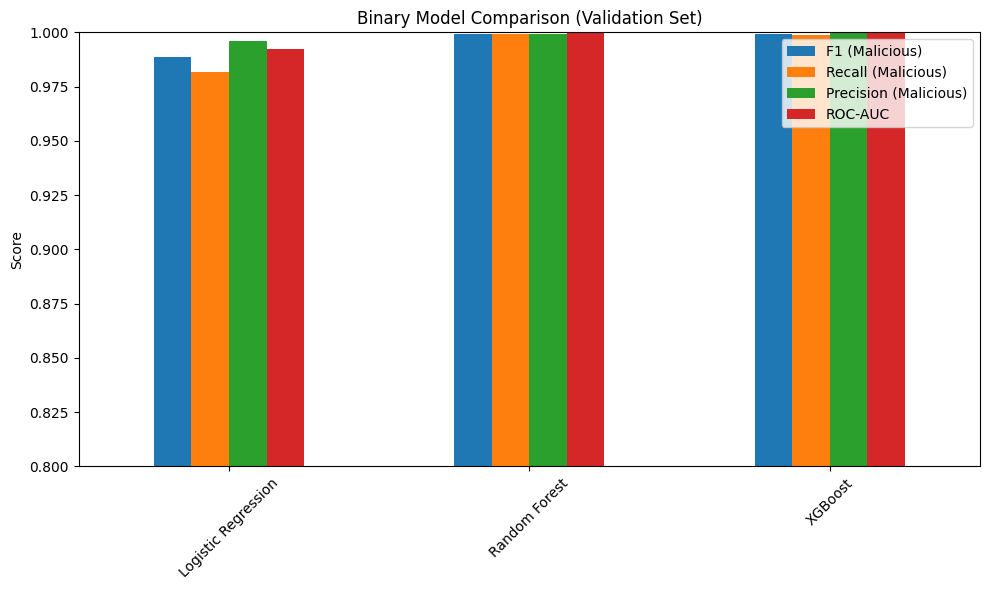

In [ ]:
results_df.plot(kind='bar', figsize=(10, 6))
plt.title("Binary Model Comparison (Validation Set)")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.ylim(0.8, 1.0) # Zoom in on high performers
plt.tight_layout()
plt.show()

#### Metric Heatmap

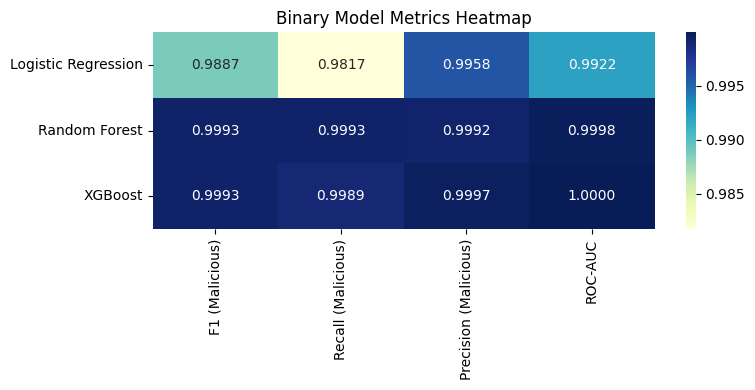

In [ ]:
plt.figure(figsize=(8, 4))
sns.heatmap(results_df, annot=True, fmt=".4f", cmap="YlGnBu")
plt.title("Binary Model Metrics Heatmap")
plt.tight_layout()
plt.show()

#### Confusion Matrix

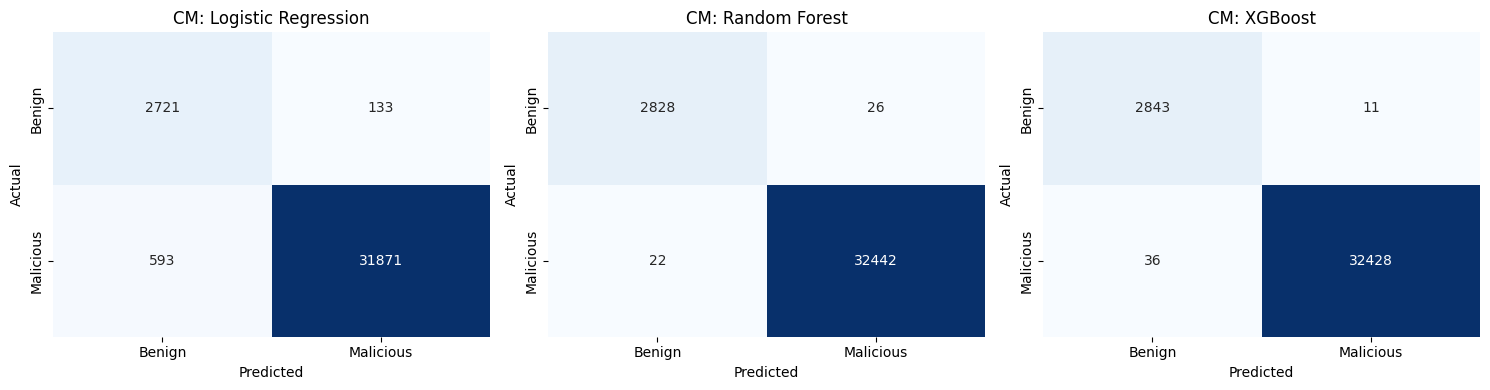

In [ ]:
# --- Plot Binary Confusion Matrices (Side-by-Side) ---
fig, axes = plt.subplots(1, len(binary_models), figsize=(5 * len(binary_models), 4))
if len(binary_models) == 1: axes = [axes] # Handle single model case

for i, (name, y_pred) in enumerate(binary_predictions.items()):
    cm = confusion_matrix(y_bin_val, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axes[i],
                xticklabels=['Benign', 'Malicious'],
                yticklabels=['Benign', 'Malicious'])
    axes[i].set_title(f"CM: {name}")
    axes[i].set_xlabel("Predicted")
    axes[i].set_ylabel("Actual")

plt.tight_layout()
plt.show()

#### Save best binary model

In [ ]:
# Save Best Pipeline
joblib.dump(best_binary_pipeline, PATHS["BINARY_PIPELINE"])
print(f"Saved best binary pipeline to {PATHS['BINARY_PIPELINE']}")

# If XGBoost is best, specifically save it using native .save_model()
if best_binary_model_name == "XGBoost":
  # Save preprocessor parts
  preproc_pipe = best_binary_pipeline[:-1]
  preproc_path = os.path.join(ARTIFACTS_DIR, "binary_preprocessor.pkl")
  joblib.dump(preproc_pipe, preproc_path)
  print(f"Saved binary preprocessor to: {preproc_path}")

  # Save xgboost
  xgb_path = os.path.join(ARTIFACTS_DIR, "binary_xgboost.json")
  best_binary_pipeline.named_steps['model'].save_model(xgb_path)
  print(f"Separately saved XGBoost native model to: {xgb_path}")

Saved best binary pipeline to /content/drive/MyDrive/Datasets/TII-SSRC-23/Artifacts/binary_pipeline.pkl
Saved binary preprocessor to: /content/drive/MyDrive/Datasets/TII-SSRC-23/Artifacts/binary_preprocessor.pkl
Separately saved XGBoost native model to: /content/drive/MyDrive/Datasets/TII-SSRC-23/Artifacts/binary_xgboost.json


### Multiclass Classification

#### Label Encoding

In [ ]:
# Encode Labels
label_encoder = LabelEncoder()
y_mul_train_enc = label_encoder.fit_transform(y_mul_train)
y_mul_val_enc = label_encoder.transform(y_mul_val)
num_classes = len(label_encoder.classes_)
print(f"Classes: {label_encoder.classes_}")

Classes: ['Audio' 'Background' 'Browsing' 'Bruteforce' 'DoS'
 'Information Gathering' 'Mirai' 'Text' 'Video']


#### Multiclass Training

In [ ]:
# =========================================
# Multiclass Classification (Comparison)
# =========================================
print("\n--- Training Multiclass Classifiers ---")

# Define Multiclass Models
multi_models = {
    "Logistic Regression": LogisticRegression(
        max_iter=2000,
        solver="lbfgs",
        n_jobs=-1,
        random_state=RANDOM_STATE
    ),
    "Random Forest": RandomForestClassifier(
        n_estimators=150,
        n_jobs=-1,
        random_state=RANDOM_STATE
    ),
    "XGBoost": XGBClassifier(
        objective='multi:softprob',
        tree_method="hist",
        eval_metric='mlogloss',
        n_jobs=-1,
        random_state=RANDOM_STATE
    )
}

multi_results = {}
multi_predictions = {}
best_multi_score = 0
best_multi_model_name = ""
best_multi_pipeline = None

for name, model in tqdm(multi_models.items(), desc="Multiclass Models"):
    pipe = Pipeline([
        ('preprocessor', preprocessor),
        ('selector', selector),
        ('model', model)
    ])

    pipe.fit(X_train, y_mul_train_enc)
    y_pred_enc = pipe.predict(X_val)
    multi_predictions[name] = y_pred_enc

    # Use Macro F1 for multiclass to value all classes equally
    f1_macro = f1_score(y_mul_val_enc, y_pred_enc, average='macro')

    multi_results[name] = {
        "F1 (Macro)": f1_macro,
        "Accuracy": accuracy_score(y_mul_val_enc, y_pred_enc),
        "Precision": precision_score(y_mul_val_enc, y_pred_enc, average='macro', zero_division=0),
        "Recall": recall_score(y_mul_val_enc, y_pred_enc, average='macro'),
    }

    print(f"\n{name} Validation Report:\n{classification_report(y_mul_val_enc, y_pred_enc, target_names=label_encoder.classes_, digits=4, zero_division=0)}")

    if f1_macro > best_multi_score:
        best_multi_score = f1_macro
        best_multi_model_name = name
        best_multi_pipeline = pipe

print(f"Best Multiclass Model: {best_multi_model_name} (Macro F1: {best_multi_score:.4f})")


--- Training Multiclass Classifiers ---


Multiclass Models:  33%|███▎      | 1/3 [00:18<00:37, 18.87s/it]


Logistic Regression Validation Report:
                       precision    recall  f1-score   support

                Audio     1.0000    0.3636    0.5333        33
           Background     0.0000    0.0000    0.0000         5
             Browsing     0.9945    0.9707    0.9824      2591
           Bruteforce     0.6752    0.3619    0.4712      1097
                  DoS     0.9619    0.9676    0.9648     24034
Information Gathering     0.8778    0.9095    0.8934      5634
                Mirai     0.4839    0.5851    0.5297      1699
                 Text     0.7812    0.5556    0.6494        45
                Video     0.6000    0.3000    0.4000       180

             accuracy                         0.9167     35318
            macro avg     0.7083    0.5571    0.6027     35318
         weighted avg     0.9168    0.9167    0.9146     35318



Multiclass Models:  67%|██████▋   | 2/3 [00:50<00:26, 26.34s/it]


Random Forest Validation Report:
                       precision    recall  f1-score   support

                Audio     0.7941    0.8182    0.8060        33
           Background     1.0000    0.8000    0.8889         5
             Browsing     0.9869    0.9884    0.9877      2591
           Bruteforce     0.9964    0.9964    0.9964      1097
                  DoS     0.9985    0.9988    0.9986     24034
Information Gathering     1.0000    0.9993    0.9996      5634
                Mirai     0.9800    0.9782    0.9791      1699
                 Text     1.0000    0.8000    0.8889        45
                Video     0.7946    0.8167    0.8055       180

             accuracy                         0.9957     35318
            macro avg     0.9500    0.9107    0.9278     35318
         weighted avg     0.9957    0.9957    0.9957     35318



Multiclass Models: 100%|██████████| 3/3 [01:13<00:00, 24.48s/it]


XGBoost Validation Report:
                       precision    recall  f1-score   support

                Audio     0.8276    0.7273    0.7742        33
           Background     1.0000    0.4000    0.5714         5
             Browsing     0.9854    0.9931    0.9892      2591
           Bruteforce     0.9973    0.9973    0.9973      1097
                  DoS     0.9981    0.9993    0.9987     24034
Information Gathering     0.9998    0.9996    0.9997      5634
                Mirai     0.9880    0.9729    0.9804      1699
                 Text     0.9714    0.7556    0.8500        45
                Video     0.8229    0.8000    0.8113       180

             accuracy                         0.9959     35318
            macro avg     0.9545    0.8494    0.8858     35318
         weighted avg     0.9958    0.9959    0.9958     35318

Best Multiclass Model: Random Forest (Macro F1: 0.9278)


#### Results

In [ ]:
m_results_df = pd.DataFrame(multi_results).T
print("\nMulticlass Comparison:\n", m_results_df)


Multiclass Comparison:
                      F1 (Macro)  Accuracy  Precision    Recall
Logistic Regression    0.602688  0.916728   0.708290  0.557101
Random Forest          0.927847  0.995668   0.950047  0.910659
XGBoost                0.885805  0.995894   0.954504  0.849445


#### Comparison Plot

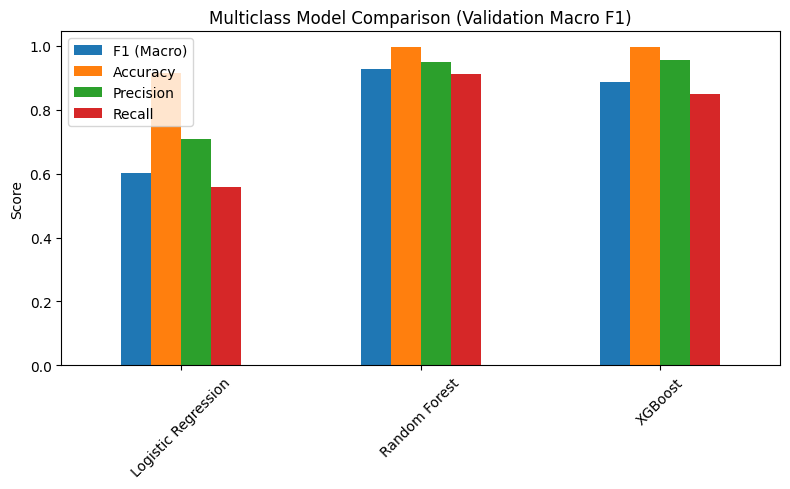

In [ ]:
# Comparison Plot
m_results_df.plot(kind='bar', figsize=(8, 5))
plt.title("Multiclass Model Comparison (Validation Macro F1)")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### Metrics Heatmap

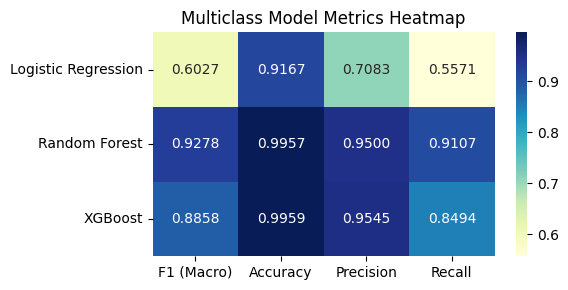

In [ ]:
# --- Multiclass Metrics Heatmap ---
plt.figure(figsize=(6, 3))
sns.heatmap(m_results_df, annot=True, fmt=".4f", cmap="YlGnBu")
plt.title("Multiclass Model Metrics Heatmap")
plt.tight_layout()
plt.show()

### Confusion Matrix

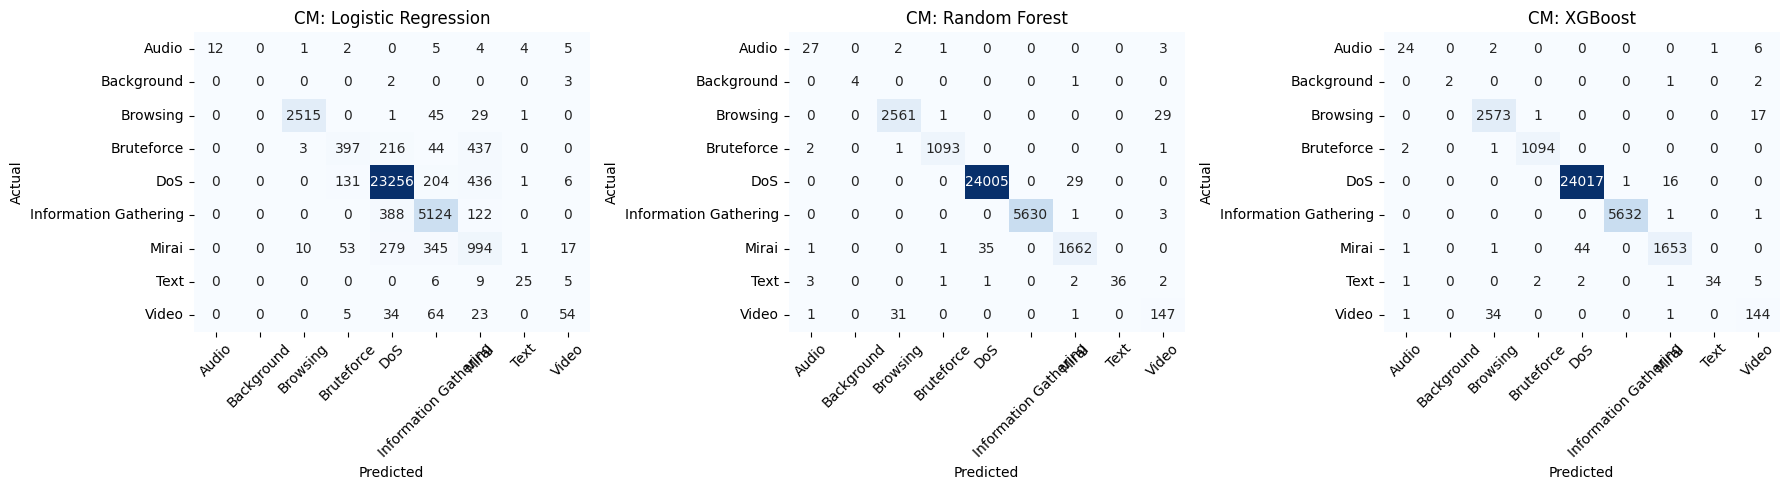

In [ ]:
fig, axes = plt.subplots(1, len(multi_models), figsize=(6 * len(multi_models), 5))
if len(multi_models) == 1: axes = [axes]

for i, (name, y_pred_enc) in enumerate(multi_predictions.items()):
    cm = confusion_matrix(y_mul_val_enc, y_pred_enc)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axes[i],
                xticklabels=label_encoder.classes_,
                yticklabels=label_encoder.classes_)
    axes[i].set_title(f"CM: {name}")
    axes[i].set_xlabel("Predicted")
    axes[i].set_ylabel("Actual")
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

#### Save best model

In [ ]:
# Save artifacts
joblib.dump(label_encoder, PATHS["LABEL_ENCODER"])
joblib.dump(best_multi_pipeline, PATHS["MULTICLASS_PIPELINE"])
print("Saved best multiclass pipeline and encoder.")

# EXTRA: If XGBoost is best, specifically save it using native .save_model()
if best_multi_model_name == "XGBoost":
    xgb_multi_path = os.path.join(ARTIFACTS_DIR, "multiclass_xgboost.json")
    # Extract the actual XGBClassifier from the named steps of the pipeline
    best_multi_pipeline.named_steps['model'].save_model(xgb_multi_path)
    print(f"Separately saved Multiclass XGBoost native model to: {xgb_multi_path}")

Saved best multiclass pipeline and encoder.


## Unsupervised Learning
- The idea for unsupervised learning:
1. Train models only on benign traffic
2. During inference, detect whether new samples deviate significantly to determine anomalies

### Data Loading and Splitting

In [ ]:
df = pd.read_csv(PATHS["CLEAN_DATA"])

# Separate Benign and Malicious
df_benign = df[df['Label'] == 0].copy()
df_malicious = df[df['Label'] == 1].copy()

print(f"Total Benign: {df_benign.shape[0]}")
print(f"Total Malicious: {df_malicious.shape[0]}")

Total Benign: 19023
Total Malicious: 216430


### Prepare Features

In [ ]:
# Prepare Features (Drop labels)
drop_cols = ["Label", "Traffic Type", "Traffic Subtype"]
X_benign = df_benign.drop(columns=[c for c in drop_cols if c in df_benign.columns])
X_malicious = df_malicious.drop(columns=[c for c in drop_cols if c in df_malicious.columns])

### Split Benign Data for Training

In [ ]:
# Pure benign training set
X_train_benign, X_temp_benign = train_test_split(
    X_benign, test_size=0.3, random_state=RANDOM_STATE
)
X_val_benign, X_test_benign = train_test_split(
    X_temp_benign, test_size=0.5, random_state=RANDOM_STATE
)

print(f"Benign Train: {X_train_benign.shape[0]}")
print(f"Benign Val:   {X_val_benign.shape[0]}")
print(f"Benign Test:  {X_test_benign.shape[0]}")

Benign Train: 13316
Benign Val:   2853
Benign Test:  2854


### Create Mixed Validation and Test Sets

In [ ]:
# Use 100% of benign val/test, and sample malicious to match or exceed it.
# For a robust test, a 1:10 benign:malicious ratio in test to match the original data roughly.
n_mal_val = min(len(X_malicious) // 2, len(X_val_benign) * 10)
n_mal_test = min(len(X_malicious) - n_mal_val, len(X_test_benign) * 10)

X_mal_val = X_malicious.sample(n=n_mal_val, random_state=RANDOM_STATE)
X_mal_test = X_malicious.drop(X_mal_val.index).sample(n=n_mal_test, random_state=RANDOM_STATE)

# Combine to create X_val and X_test (mixed)
X_val = pd.concat([X_val_benign, X_mal_val])
y_val = np.concatenate([np.zeros(len(X_val_benign)), np.ones(len(X_mal_val))])

X_test = pd.concat([X_test_benign, X_mal_test])
y_test = np.concatenate([np.zeros(len(X_test_benign)), np.ones(len(X_mal_test))])

print(f"Mixed Val Set: {X_val.shape[0]} (Benign: {len(X_val_benign)}, Malicious: {len(X_mal_val)})")
print(f"Mixed Test Set: {X_test.shape[0]} (Benign: {len(X_test_benign)}, Malicious: {len(X_mal_test)})")

Mixed Val Set: 31383 (Benign: 2853, Malicious: 28530)
Mixed Test Set: 31394 (Benign: 2854, Malicious: 28540)


### Preprocessing Pipeline

In [ ]:
categorical_cols = [col for col in X_train_benign.columns if "Protocol_" in col]
numerical_cols = [col for col in X_train_benign.columns if col not in categorical_cols]

# Numeric Transformer
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', MinMaxScaler())
])

# Preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_cols),
        ('cat', 'passthrough', categorical_cols)
])

### Fit and Transform

In [ ]:
# Fit preprocessor on pure benign train data
print("Fitting preprocessor on benign training data...")
preprocessor.fit(X_train_benign)

# Transform all sets for later use
X_train_scaled = preprocessor.transform(X_train_benign)
X_val_scaled = preprocessor.transform(X_val)
X_test_scaled = preprocessor.transform(X_test)

# Save the preprocessor pipeline
joblib.dump(preprocessor, PATHS["UNSUPERVISED_PIPELINE"])
print("Preprocessor saved.")

Fitting preprocessor on benign training data...
Preprocessor saved.


### Train-test split

### Model Training and Validation
- Candidate Models
1. One-Class SVM: Learns boundary around benign traffic
2. Isolation Forest: Isolates anomalies by random splits
3. Local Outlier Factor (LOF): Detects density anomalies
5. Autoencoder (AE): Will be trained to reconstruct benign traffic.

In [ ]:
print("\n--- Training Standard Unsupervised Models ---")

# Define models
anomaly_models = {
    "Isolation Forest": IsolationForest(contamination=0.01, n_jobs=-1, random_state=RANDOM_STATE),
    "One-Class SVM": OneClassSVM(kernel="rbf", gamma="scale", nu=0.01),
    "Local Outlier Factor": LocalOutlierFactor(n_neighbors=20, novelty=True, contamination=0.01, n_jobs=-1)
}

model_results = {}

for name, model in anomaly_models.items():
    print(f"Training {name}...")
    # Fit on benign only
    model.fit(X_train_scaled)

    # Predict on mixed validation set
    # These models output +1 for inliers (benign), -1 for outliers (malicious)
    y_pred_raw = model.predict(X_val_scaled)

    # Convert to 0/1 format (0=Benign, 1=Malicious)
    y_pred = np.where(y_pred_raw == 1, 0, 1)

    # Calculate Scores (Decision Function) for ROC
    # Not all models have decision_function, try/except handles this.
    try:
        y_scores = model.decision_function(X_val_scaled)
        y_scores = -y_scores
    except AttributeError:
         try:
             y_scores = -model.score_samples(X_val_scaled)
         except AttributeError:
             y_scores = y_pred # Fallback to hard predictions if no scores available

    # Metrics
    roc_auc = roc_auc_score(y_val, y_scores) if len(np.unique(y_val)) > 1 else 0.5

    print(f"{name} Validation Report:\n{classification_report(y_val, y_pred, digits=4)}")

    model_results[name] = {
        "F1 (Malicious)": f1_score(y_val, y_pred, pos_label=1),
        "Precision (Malicious)": precision_score(y_val, y_pred, pos_label=1),
        "Recall (Malicious)": recall_score(y_val, y_pred, pos_label=1),
        "ROC-AUC": roc_auc,
        "y_scores": y_scores # Save for plotting later
    }


--- Training Standard Unsupervised Models ---
Training Isolation Forest...
Isolation Forest Validation Report:
              precision    recall  f1-score   support

         0.0     0.0911    0.9923    0.1669      2853
         1.0     0.9272    0.0098    0.0194     28530

    accuracy                         0.0991     31383
   macro avg     0.5091    0.5011    0.0931     31383
weighted avg     0.8511    0.0991    0.0328     31383

Training One-Class SVM...
One-Class SVM Validation Report:
              precision    recall  f1-score   support

         0.0     0.1494    0.9895    0.2596      2853
         1.0     0.9976    0.4365    0.6073     28530

    accuracy                         0.4868     31383
   macro avg     0.5735    0.7130    0.4334     31383
weighted avg     0.9205    0.4868    0.5757     31383

Training Local Outlier Factor...
Local Outlier Factor Validation Report:
              precision    recall  f1-score   support

         0.0     0.1336    0.9895    0.2354    

### Unsupervised Learning Results

In [ ]:
# Create results df
results_df = pd.DataFrame(model_results).T.drop(columns=["y_scores"])
print("\nUnsupervised Model Comparison:\n", results_df)


Unsupervised Model Comparison:
                      F1 (Malicious) Precision (Malicious) Recall (Malicious)  \
Isolation Forest           0.019423              0.927152           0.009814   
One-Class SVM              0.607305              0.997597           0.436523   
Local Outlier Factor       0.527266              0.997075           0.358395   

                       ROC-AUC  
Isolation Forest      0.932089  
One-Class SVM         0.714814  
Local Outlier Factor  0.952167  


### Autoencoder Training

In [ ]:
# =========================================
# Autoencoder (Deep Anomaly Detection)
# =========================================
print("\n--- Training Autoencoder ---")

input_dim = X_train_scaled.shape[1]

# Architecture designed for tabular data reconstruction
ae_model = Sequential([
    Input(shape=(input_dim,)),
    Dense(128, activation="relu"),
    BatchNormalization(),
    Dropout(0.2),
    Dense(64, activation="relu"),
    # Bottleneck
    Dense(32, activation="relu", activity_regularizer=regularizers.l1(1e-5)),
    # Decoder
    Dense(64, activation="relu"),
    Dense(128, activation="relu"),
    BatchNormalization(),
    Dense(input_dim, activation="sigmoid") # Sigmoid because data is MinMax scaled [0,1]
])

ae_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mae')
ae_model.summary()

# Train on pure benign data. Target is itself.
history = ae_model.fit(
    X_train_scaled, X_train_scaled,
    validation_data=(X_val_scaled[y_val==0], X_val_scaled[y_val==0]),
    epochs=100,
    batch_size=64,
    shuffle=True,
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)
    ],
    verbose=0
)

print("Autoencoder training complete.")


--- Training Autoencoder ---


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │        10,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 81)             │        10,449 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 42,737 (166.94 KB)

 Trainable params: 42,225 (164.94 KB)

 Non-trainable params: 512 (2.00 KB)

Autoencoder training complete.


### Evaluation and Threshold Tuning

#### Youden's J statistic vs. F1-Score

In [ ]:
# Reconstruction error
X_val_recon = ae_model.predict(X_val_scaled, verbose=0)
mae_val = np.mean(np.abs(X_val_scaled - X_val_recon), axis=1)

# Option A: Youden's J Statistic
fpr, tpr, thresholds_roc = roc_curve(y_val, mae_val)
j_scores = tpr - fpr
best_idx_j = np.argmax(j_scores)
threshold_j = thresholds_roc[best_idx_j]
f1_j = f1_score(y_val, (mae_val > threshold_j).astype(int))

# Option B: Optimal F1 Score
# Find the best F1 across all thresholds efficiently
precisions, recalls, thresholds_pr = precision_recall_curve(y_val, mae_val)

# Calculate F1 for each threshold
with np.errstate(divide='ignore', invalid='ignore'):
    f1_scores = 2 * (precisions * recalls) / (precisions + recalls)
best_idx_f1 = np.nanargmax(f1_scores)

# thresholds_pr is 1 element shorter than precisions/recalls
threshold_f1 = thresholds_pr[best_idx_f1] if best_idx_f1 < len(thresholds_pr) else thresholds_pr[-1]
f1_opt = np.nanmax(f1_scores)

print(f"\nThreshold Comparison:")
print(f" - Youden's J Threshold: {threshold_j:.6f} (F1: {f1_j:.4f})")
print(f" - Optimal F1 Threshold: {threshold_f1:.6f} (F1: {f1_opt:.4f})")


Threshold Comparison:
 - Youden's J Threshold: 0.010790 (F1: 0.9835)
 - Optimal F1 Threshold: 0.007929 (F1: 0.9882)


#### Select best threshold

In [ ]:
# Select Winner
if f1_opt >= f1_j:
    best_threshold = threshold_f1
    print(">> Selected: Optimal F1 Threshold")
else:
    best_threshold = threshold_j
    print(">> Selected: Youden's J Threshold")

>> Selected: Optimal F1 Threshold


#### Autoencoder Metrics

In [ ]:
# Generate Predictions based on threshold
y_pred_ae = (mae_val > best_threshold).astype(int)

# Metrics for Autoencoder
ae_roc_auc = roc_auc_score(y_val, mae_val)
print(f"\nAutoencoder Validation Report (t={best_threshold:.4f}):\n{classification_report(y_val, y_pred_ae, digits=4)}")

model_results["Autoencoder"] = {
    "F1 (Malicious)": f1_score(y_val, y_pred_ae, pos_label=1),
    "Precision (Malicious)": precision_score(y_val, y_pred_ae, pos_label=1),
    "Recall (Malicious)": recall_score(y_val, y_pred_ae, pos_label=1),
    "ROC-AUC": ae_roc_auc,
    "y_scores": mae_val # MAE is the anomaly score
}


Autoencoder Validation Report (t=0.0079):
              precision    recall  f1-score   support

         0.0     0.9888    0.7708    0.8663      2853
         1.0     0.9776    0.9991    0.9882     28530

    accuracy                         0.9784     31383
   macro avg     0.9832    0.8849    0.9272     31383
weighted avg     0.9786    0.9784    0.9771     31383



#### Save Artifacts

In [ ]:
# Save Autoencoder Artifacts
ae_model.save(PATHS["AUTOENCODER_MODEL"])
with open(PATHS["AE_THRESHOLD"], "w") as f:
    f.write(str(best_threshold))
print("Autoencoder model and threshold saved.")

Autoencoder model and threshold saved.


### Unsupervised Models Comparison

#### Results

In [ ]:
results_df = pd.DataFrame(model_results).T.drop(columns=["y_scores"])
print(results_df)

                     F1 (Malicious) Precision (Malicious) Recall (Malicious)  \
Isolation Forest           0.019423              0.927152           0.009814   
One-Class SVM              0.607305              0.997597           0.436523   
Local Outlier Factor       0.527266              0.997075           0.358395   
Autoencoder                 0.98823              0.977571           0.999124   

                       ROC-AUC  
Isolation Forest      0.932089  
One-Class SVM         0.714814  
Local Outlier Factor  0.952167  
Autoencoder           0.956845  


#### Bar Chart

<Figure size 1000x600 with 0 Axes>

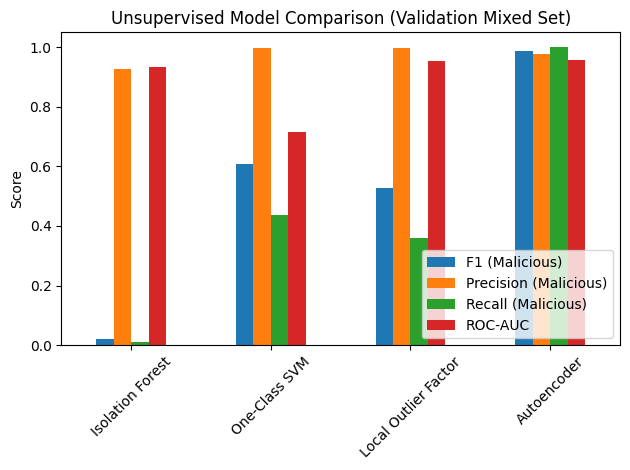

In [ ]:
plt.figure(figsize=(10, 6))
results_df.plot(kind='bar')
plt.title("Unsupervised Model Comparison (Validation Mixed Set)")
plt.ylabel("Score")
plt.ylim(0.0, 1.05)
plt.xticks(rotation=45)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

#### ROC Curve

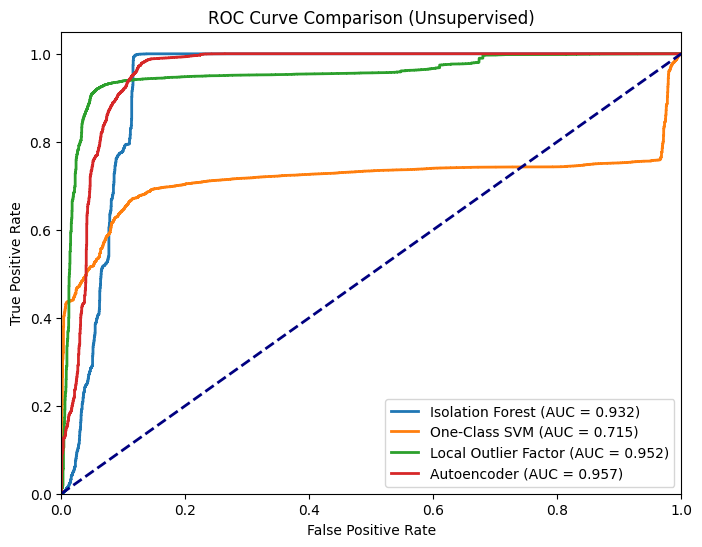

In [ ]:
plt.figure(figsize=(8, 6))
for name, res in model_results.items():
    fpr, tpr, _ = roc_curve(y_val, res["y_scores"])
    auc_score = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {auc_score:.3f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison (Unsupervised)')
plt.legend(loc="lower right")
plt.show()

#### Autoencoder Reconstruction Error Plot

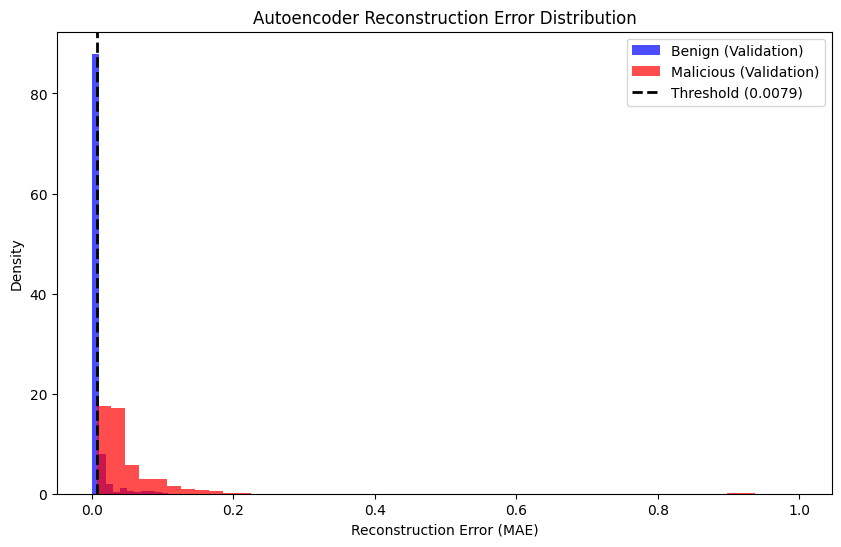

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(mae_val[y_val == 0], bins=50, alpha=0.7, label='Benign (Validation)', color='blue', density=True)
plt.hist(mae_val[y_val == 1], bins=50, alpha=0.7, label='Malicious (Validation)', color='red', density=True)
plt.axvline(best_threshold, color='k', linestyle='--', linewidth=2, label=f'Threshold ({best_threshold:.4f})')
plt.xlabel('Reconstruction Error (MAE)')
plt.ylabel('Density')
plt.title('Autoencoder Reconstruction Error Distribution')
plt.legend()
plt.show()